# Imports

In [1]:
import os

os.chdir("/home/ivanr/git/document_information_extraction/")

In [2]:
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import pearsonr
import itertools

In [3]:
from src.data.wikipedia.wiki_data_base import retrieve_query

# Statics

In [4]:
from src.data.data_statics import SQL_WIKI_DUMP, TEMP_DB

In [5]:
INFO_COLUMNS = [
    "summary_word_count",
    "body_word_count",
    "novelty_tokens",
    "novelty_bigrams",
    "novelty_trigrams",
    "semantic_similarity",
]

# Read data

In [6]:
query = """
    SELECT  ar.pageid
           ,ar.title
           ,ar.summary_word_count
           ,ar.body_word_count
           ,nov.novelty_tokens
           ,nov.novelty_bigrams
           ,nov.novelty_trigrams
           ,sm.semantic_similarity
           
    FROM wiki_article_novelty nov
    INNER JOIN article_level_info ar
        ON ar.pageid=nov.pageid
    INNER JOIN wiki_article_cosine_similarity sm
        ON ar.pageid=sm.pageid
"""

In [7]:
wiki_info_df = retrieve_query(query, out_f=SQL_WIKI_DUMP)
wiki_info_df = pd.DataFrame(
    wiki_info_df,
    columns=[
        "pageid",
        "title",
        "summary_word_count",
        "body_word_count",
        "novelty_tokens",
        "novelty_bigrams",
        "novelty_trigrams",
        "semantic_similarity",
    ],
)

In [8]:
# assert len(wiki_info_df) == 1424051

# Evaluate distribution

In [9]:
wiki_info_df[["novelty_tokens", "novelty_bigrams", "novelty_trigrams",]] = wiki_info_df[
    ["novelty_tokens", "novelty_bigrams", "novelty_trigrams"]
].astype(float)

/home/ivanr/anaconda3/envs/doc_info/lib/python3.7/site-packages/numpy/lib/histograms.py:905: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


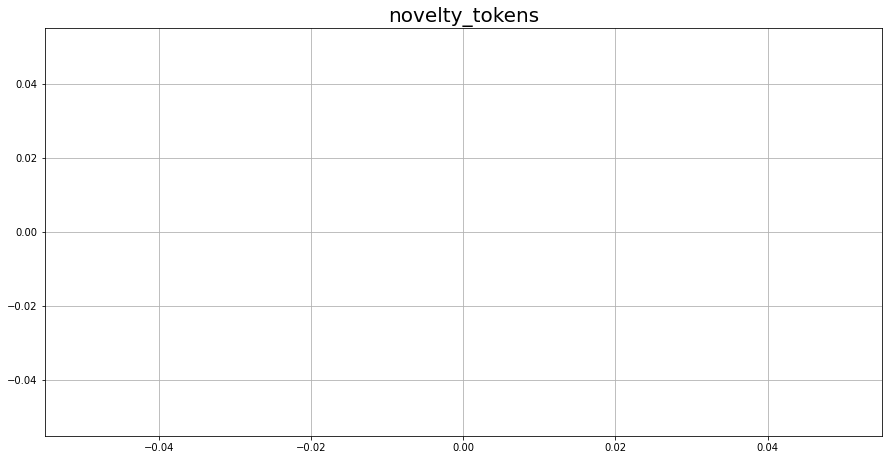

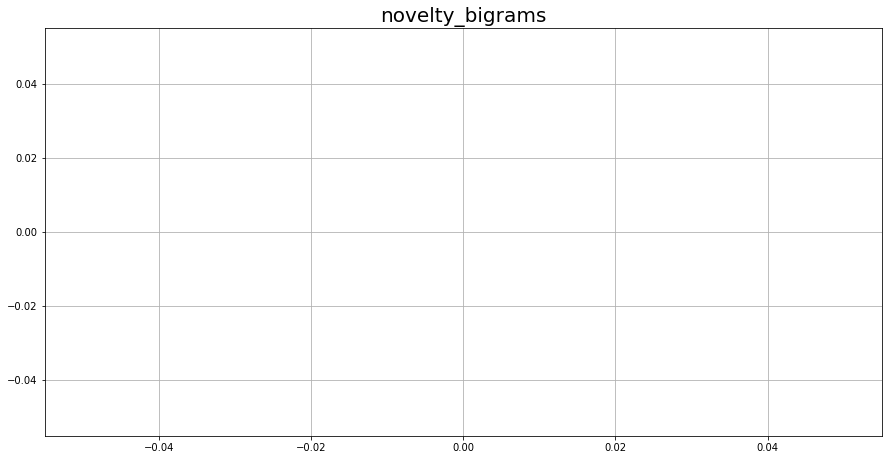

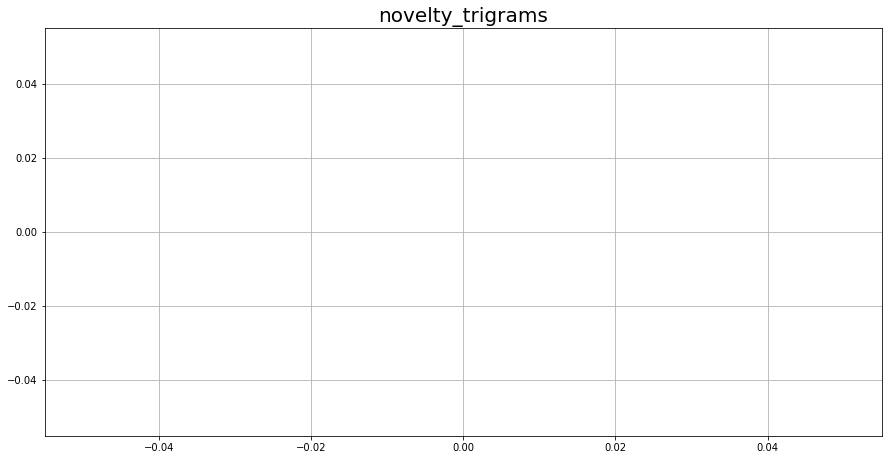

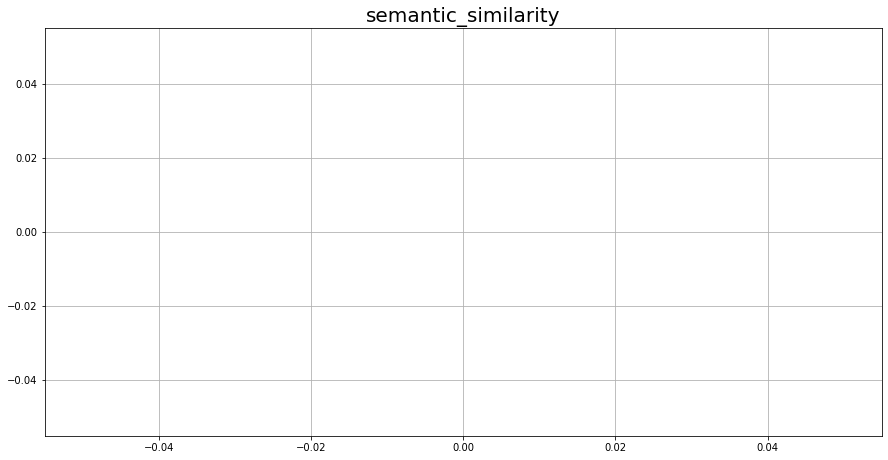

In [10]:
for var in [
    "novelty_tokens",
    "novelty_bigrams",
    "novelty_trigrams",
    "semantic_similarity",
]:
    plt.figure(figsize=(15, 7.5))
    plt.title(var, fontsize=20)
    wiki_info_df[var].hist(bins=100, density=True)
    plt.show()

In [11]:
wiki_info_df.describe()

,novelty_tokens,novelty_bigrams,novelty_trigrams
count,0.0,0.0,0.0
mean,NaN,NaN,NaN
std,NaN,NaN,NaN
min,NaN,NaN,NaN
25%,NaN,NaN,NaN
50%,NaN,NaN,NaN
75%,NaN,NaN,NaN
max,NaN,NaN,NaN


# Compare variables
## Compare correlation

In [12]:
relevant_combinations = [
    pair
    for pair in itertools.combinations(INFO_COLUMNS, 2)
    if (not (("novelty" in pair[0]) & ("novelty" in pair[1])))
    & (not (("count" in pair[0]) & ("count" in pair[1])))
]

In [13]:
for var1, var2 in itertools.combinations(INFO_COLUMNS, 2):
    corr, pval = pearsonr(wiki_info_df[var1], wiki_info_df[var2])
    print(f"{var1} - {var2} correlation of {corr:.3f} with p-value {pval:.3f}")

ValueError: x and y must have length at least 2.

## Joint distributions

In [ ]:
import matplotlib.cm as cm
from matplotlib.colors import LogNorm


def plot_joint(data, x_label, y_label, bins=(100, 100)):

    x = data[x_label]
    y = data[y_label]
    ax1 = sns.jointplot(x=x, y=y)
    ax1.ax_joint.cla()
    plt.sca(ax1.ax_joint)

    plt.hist2d(x, y, bins=bins, cmap=cm.jet, norm=LogNorm())
    plt.xlabel(x_label, fontsize=13)
    plt.ylabel(y_label, fontsize=13)

    cbar_ax = ax1.fig.add_axes([1, 0.1, 0.03, 0.7])
    cb = plt.colorbar(cax=cbar_ax)
    cb.set_label(r"$\log_{10}$ density of points", fontsize=13)

    plt.show()

In [ ]:
for var1, var2 in relevant_combinations:
    plot_joint(
        wiki_info_df,
        var1,
        var2,
        bins=(250, 250),
    )

# Sample text

In [ ]:
def custom_query(where_statement: str = "", limit: int = 3) -> str:
    return f"""
    SELECT  wk.pageid
           ,wk.section_titles
           ,wk.summary
           ,wk.body_sections
           ,wk.section_word_count
           ,ar.title
           ,ar.summary_word_count
           ,ar.body_word_count
           ,nov.novelty_tokens
           ,nov.novelty_bigrams
           ,nov.novelty_trigrams
           ,sm.semantic_similarity
           
    FROM wiki_articles wk
    INNER JOIN wiki_article_novelty nov
        on wk.pageid = nov.pageid
    INNER JOIN article_level_info ar
        ON ar.pageid=nov.pageid
    INNER JOIN wiki_article_cosine_similarity sm
        ON ar.pageid=sm.pageid
    {where_statement}
    LIMIT {limit}
            
    """


def display_samples(samples):
    for sample in samples:
        (
            pageid,
            section_titles,
            summary,
            body_sections,
            section_word_count,
            title,
            summary_word_count,
            body_word_count,
            novelty_tokens,
            novelty_bigrams,
            novelty_trigrams,
            semantic_similarity,
        ) = sample

        body_sections = pickle.loads(body_sections)
        section_word_count = pickle.loads(section_word_count)
        section_titles = pickle.loads(section_titles)

        print("*" * 25, f"pageid: {pageid}, title: {title}", "*" * 25)

        stats = pd.DataFrame(
            data=[
                [
                    pageid,
                    title,
                    summary_word_count,
                    body_word_count,
                    novelty_tokens,
                    novelty_bigrams,
                    novelty_trigrams,
                    semantic_similarity,
                ]
            ],
        )
        stats.columns = ["pageid", "title"] + INFO_COLUMNS
        print("Stats")
        print("------")
        display(stats)

        print("summary")
        print("--------")
        print(summary)

        for idx, (sect_title, body_sect, word_count) in enumerate(
            zip(
                section_titles,
                body_sections,
                section_word_count,
            )
        ):
            print(f"section {idx}: {sect_title}, word count: {word_count}")
            print("-----------------------------------------------")
            print(body_sect)

## Semantic similarity

When looking at semantic similarity, the higher semantic similarity articles seem to keep not only in a specific topic but within the same niche in that topic. As we go lower, the themes seem to be more broad. The least semantically similar topics seam to talk about different topics relevant to the summary, i.e. a lot of them discuss books and novels where the body doesnt only contain a summary of the book but also history about its release, author, etc.

### High semantic similarity

In [ ]:
samples = retrieve_query(custom_query("WHERE semantic_similarity >= .9"))
display_samples(samples)

### Medium high semantic similarity

In [ ]:
samples = retrieve_query(custom_query("WHERE semantic_similarity >= .7 AND semantic_similarity <= .725"))
display_samples(samples)

### Medium Low semantic similarity

In [ ]:
samples = retrieve_query(custom_query("WHERE semantic_similarity >= .4 AND semantic_similarity <= .425"))
display_samples(samples)

### Low semantic similarity

In [ ]:
samples = retrieve_query(custom_query("WHERE semantic_similarity >= .15 AND semantic_similarity <= .25"))
display_samples(samples)

### Low semantic similarity

In [ ]:
samples = retrieve_query(custom_query("WHERE semantic_similarity <= .1"))
display_samples(samples)

## Novelty
###  High novelty

In [ ]:
samples = retrieve_query(custom_query("WHERE novelty_tokens >= .90"))
display_samples(samples)

In [ ]:
samples = retrieve_query(custom_query("WHERE novelty_tokens >= .85 AND novelty_tokens < .90"))
display_samples(samples)

In [ ]:
samples = retrieve_query(custom_query("WHERE novelty_tokens >= .76 AND novelty_tokens < .85"))
display_samples(samples)

In [ ]:
samples = retrieve_query(custom_query("WHERE novelty_tokens >= .60 AND novelty_tokens < .7"))
display_samples(samples)

###  Medium novelty

In [ ]:
samples = retrieve_query(custom_query("WHERE novelty_tokens >= .5 AND novelty_tokens < .6"))
display_samples(samples)

In [ ]:
samples = retrieve_query(custom_query("WHERE novelty_tokens >= .4 AND novelty_tokens < .5"))
display_samples(samples)

###  Medium novelty low

In [ ]:
samples = retrieve_query(custom_query("WHERE novelty_tokens >= .3 AND novelty_tokens < .4"))
display_samples(samples)

In [ ]:
samples = retrieve_query(custom_query("WHERE novelty_tokens >= .25 AND novelty_tokens < .3"))
display_samples(samples)

###   Low novelty

In [ ]:
samples = retrieve_query(custom_query("WHERE novelty_tokens >= .15 AND novelty_tokens < .25"))
display_samples(samples)

In [ ]:
samples = retrieve_query(custom_query("WHERE novelty_tokens < .15"))
display_samples(samples)

# To keep

In [ ]:
to_keep = wiki_info_df[
    (wiki_info_df["semantic_similarity"] > 0.4)
    & (wiki_info_df["novelty_tokens"] <= 0.5)
]
print(len(to_keep))
len(to_keep) / len(wiki_info_df)

# TODO: check markup wikipedia clean up